In [8]:
import os, sys
import dotenv

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.environ.get('PATH_OPENSKY'))
from user_eval import get_df_posts 
from news_outlet_eval import get_news_feed, get_posts_from_nos

dotenv.load_dotenv('.env')    
PATH_DATA = os.environ.get('PATH_OPENSKY') + os.environ.get('PATH_REL_DATA')
PATH_USER_POSTS = PATH_DATA + 'user_posts/'

PATH_RESULTS = os.environ.get('PATH_OPENSKY') + 'results/'
PATH_USER_REPLIES_NEWS_POSTS = PATH_RESULTS + 'agg_user_replies_news_posts_2.csv'
PATH_ALL_SENTIMENTS = os.environ.get('PATH_OPENSKY') + 'results/all_sentiments_over_time.csv'

COLOR_POSITIVE = os.environ.get('COLOR_POSITIVE')
COLOR_NEUTRAL = os.environ.get('COLOR_NEUTRAL')
COLOR_NEGATIVE = os.environ.get('COLOR_NEGATIVE')

In [4]:
sent_label_mapping = { 0: 'negative', 1: 'neutral', 2: 'positive'}

df_all_replies = pd.read_csv(PATH_ALL_SENTIMENTS, index_col=0)
df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)
df_all_replies['date'] = pd.to_datetime(df_all_replies['date'], errors='coerce')

# Removing all posts present in the news feed replies df
bm_not_in_news_feed = ~df_all_replies.post_id.isin(df_news_posts.post_id)
df_all_replies = df_all_replies[bm_not_in_news_feed]

# Removing all posts that are not direct replies to posts
bm_first_depth = (df_all_replies.reply_to == df_all_replies.thread_root)
df_all_replies = df_all_replies[bm_first_depth]

reply_counts = df_all_replies.groupby('reply_to').size().sort_values(ascending=False).reset_index(name='count')


/tmp/ipykernel_1968737/2773427229.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['negative' 'neutral' 'negative' ... 'positive' 'positive' 'neutral']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all_replies.loc[:, 'sent_label'] = df_all_replies.sent_label.map(sent_label_mapping)


In [6]:
df_all_cutoff = df_all_replies[df_all_replies.reply_to.isin(reply_counts[reply_counts['count'] >= 4].reply_to.to_list())]
df_all_cutoff

,post_id,user_id,date,labels,sent_label,sent_score,reply_to,thread_root
532,79799347,527934,2024-02-13 16:55:00,NaN,neutral,0.928,6369073.0,6369073.0
649,79799462,527934,2024-02-04 03:41:00,NaN,neutral,0.658,1960204.0,1960204.0
1783,79800556,527934,2023-10-28 18:56:00,NaN,neutral,0.625,160257.0,160257.0
294,38539170,317609,2024-03-04 10:02:00,NaN,positive,0.984,38539124.0,38539124.0
600,38539863,317609,2024-02-18 12:01:00,NaN,positive,0.985,187711.0,187711.0
...,...,...,...,...,...,...,...,...
21,52363070,1057073,2023-08-24 03:50:00,NaN,neutral,0.680,18602800.0,18602800.0
27,52363077,1057073,2023-08-06 20:04:00,NaN,positive,0.455,11592045.0,11592045.0
1,68998727,1848807,2023-10-17 07:28:00,NaN,positive,0.977,2175936.0,2175936.0
1,177173027,3283530,2024-03-09 03:30:00,NaN,negative,0.884,65862.0,65862.0


[Text(0, 0, '0'), Text(1000, 0, '100000')]

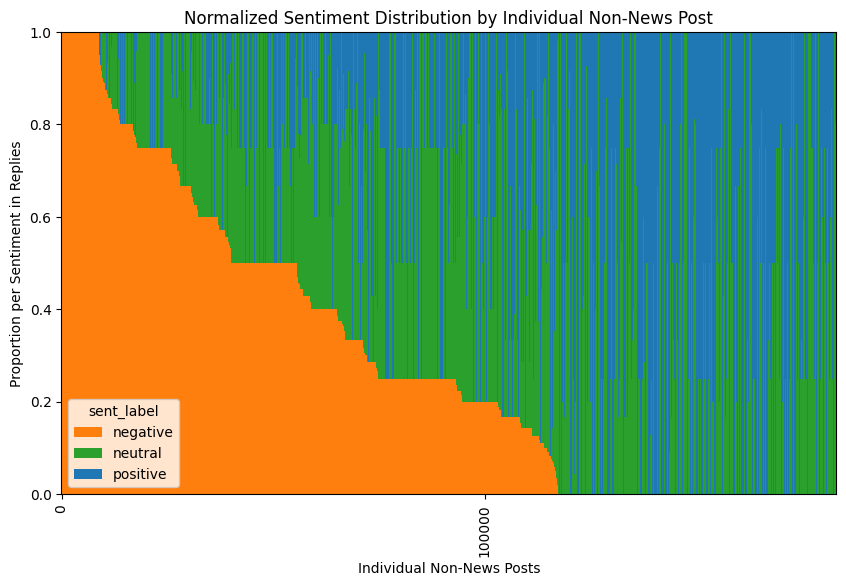

In [9]:
num_sent_replies = df_all_cutoff.groupby(['reply_to', 'sent_label']).size().unstack()

normalized_df = num_sent_replies.apply(lambda x: x / x.sum(), axis=1)
normalized_df = normalized_df.sort_values(by='negative', ascending=False)
normalized_df.replace(np.nan, 0, inplace=True)

color_map = {
    'positive': COLOR_POSITIVE,
    'neutral': COLOR_NEUTRAL,
    'negative': COLOR_NEGATIVE
}

normalized_df.reset_index(inplace=True, drop=True)
subset_normalized_df = normalized_df.iloc[::100]

ax = subset_normalized_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=1, edgecolor=None, color=[color_map[col] for col in subset_normalized_df.columns])
ax.set_xlabel('Individual Non-News Posts')
ax.set_ylabel('Proportion per Sentiment in Replies')
ax.set_title('Normalized Sentiment Distribution by Individual Non-News Post')

ax.set_ylim(0, 1)

# Set xticks to the original indices of the sampled rows
xticks = range(0, len(subset_normalized_df), 1000)
ax.set_xticks(xticks)
ax.set_xticklabels(subset_normalized_df.index[::1000])

In [11]:
df_all_cutoff.to_csv(PATH_RESULTS + 'nonnews_cutoff_v1.csv', index=False)